In [2]:
import os
import tensorflow as tf
from tensorflow.keras import Sequential,layers,Input,optimizers, utils,callbacks
import kaggle
from PIL import Image
import glob
import numpy as np
import shutil
import matplotlib.pyplot as plt
import hashlib

## Pipeline of preprocessing for basic CNN

In [3]:
raw_data_path = '../raw_data'
merged_path = '../merged_data'

In [4]:
# Download latest version
def dataset_download(raw_data_path):
    print("We are downloading raw datasets....")
    print("-" * 40)
    raw_data_path = "../raw_data"
    if os.path.exists(raw_data_path) and len(os.listdir(raw_data_path)) > 1:
        print(f'Datasets already downloaded ')
    else:
        kaggle.api.dataset_download_files(
            "yangsangtai/tiny-genimage",
            path="../raw_data",
            unzip=True
        )
    print("-" * 40)

In [5]:
# get datasets
def get_available_datasets(raw_data_path):
    print("We are getting available datasets.....")
    print("-" * 40)
    datasets = os.listdir(raw_data_path)
    available_datasets = []
    for dataset in datasets:
        train_path= os.path.join(raw_data_path,dataset,"train")
        if os.path.exists(train_path):
            available_datasets.append(dataset)
        else:
            print(f"{dataset} is available")

    print(f"There are {len(available_datasets)} datasets available.")
    print(f"they are {available_datasets}")
    print(f'Done')
    print("-" * 40)
    return available_datasets


In [6]:
available_datasets = get_available_datasets(raw_data_path=raw_data_path)

We are getting available datasets.....
----------------------------------------
.DS_Store is available
There are 7 datasets available.
they are ['imagenet_glide', 'imagenet_midjourney', 'imagenet_ai_0424_wukong', 'imagenet_ai_0508_adm', 'imagenet_ai_0424_sdv5', 'imagenet_ai_0419_vqdm', 'imagenet_ai_0419_biggan']
Done
----------------------------------------


In [7]:
# step 1 : check if pictures are valid
def check_image_valid(image_path):
    try:
        img = Image.open(image_path)
        # check if the image is valid
        img.verify()
        img = Image.open(image_path)
        # convert image to RGB
        img = img.convert(mode="RGB")
        # check the size of image
        width,height = img.size
        if width <32 or height <32:
            print(f"This picture :{image_path} is too small")
            return False
        # check the content of image
        img_array = np.array(img)
        if np.std(img_array)<1 :
            print(f"This picture :{image_path} has no content")
            return False
        return True
    except Exception as e:
        print(str(e))
        return False


In [8]:
# step 2 : clean the raw datasets
def clean_one_dataset(base_path,dataset_name):

    stats = {
    "total": 0,
    "valid" : 0,
    "invalid": 0,
    'removed': []
    }
    dataset_path = os.path.join(base_path,dataset_name)

    for split in ['train','val']:
        split_path = os.path.join(dataset_path,split)
        if not os.path.exists(split_path):
            continue
        for class_name in ['ai','nature']:
            class_path = os.path.join(split_path,class_name)
            if not os.path.exists(class_path):
                continue
            print(f"We are checking {dataset_path}/{split}/{class_name}")

            # check all the pictures of current directory

            image_files = [f for f in os.listdir(class_path)]

            for image_file in image_files:
                image_path = os.path.join(class_path,image_file)
                stats['total']+=1
                status = check_image_valid(image_path)
                if status == True:
                    stats['valid'] +=1
                else:
                    stats['invalid']+=1
                    stats['removed'].append(f"{image_file}")
                    try:
                        os.remove(image_path)
                        print(f"{image_path} is invalid")
                    except Exception as e:
                        print(f"{image_path} cannot be removed")

    print(f"Stats for {dataset_name}:")
    print(f"There are total {stats['total']} pictures")
    print(f"There are {stats['valid']} valid pictures")
    print(f"There are {stats['invalid']} invalid pictures")
    return stats

In [9]:
def clean_all_datasets(raw_data_path,available_datasets):
    print("We are cleaning all datasets....")
    print("-" * 40)
    all_stats = {}
    for dataset in available_datasets:
        all_stats[dataset] = clean_one_dataset(raw_data_path,dataset)
    print("Done!")
    print("-" * 40)

In [10]:
def get_image_hash(image_path):
    """
    Calculate the hash value
    """
    try:
        with open(image_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    except:
        return None

In [11]:
 # step 3 : Remove duplicates picture
def remove_duplicates(available_datasets,raw_data_path):
    print("we are removing duplicates......")
    print("-" * 40)
    # step 3 : Remove duplicates picture
    seen_hash = {}
    duplicates = []
    for dataset in available_datasets:
        dataset_path = os.path.join(raw_data_path, dataset)
        print(dataset_path)
        if not os.path.exists(dataset_path):
            continue
        for split in ["train", "val"]:
            for class_name in ["ai", "nature"]:
                class_path = os.path.join(dataset_path, split, class_name)
                if not os.path.exists(class_path):
                    continue
                for img_file in os.listdir(class_path):
                    if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        continue
                    image_path = os.path.join(class_path, img_file)
                    image_hash = get_image_hash(image_path)
                    if image_hash is None:
                        print(f"Skip (no hash): {image_path}")
                        continue
                    if image_hash in seen_hash:
                        duplicates.append((image_path, seen_hash[image_hash]))
                        try:
                            os.remove(image_path)
                            print(f"Removed duplicate: {image_path} (same as {seen_hash[image_hash]})")
                        except Exception as e:
                            print(f"Cannot remove {image_path}: {e}")
                    else:
                        seen_hash[image_hash] = image_path

    print(f"Total duplicates removed/found: {len(duplicates)}")
    for dup, orig in duplicates[:20]:
        print(f"{dup} -> {orig}")
    print("Done!")
    print("-" * 40)

In [12]:
# step 4 : Merge cleanned dataset to a new folder
def merge_clean_datasets(dataset,raw_data_path,target_path):

    stats = {
    'train':{'ai':0, 'nature':0},
    'val':{'ai':0,'nature':0}
    }
    # create the directories
    merged_train_path = os.path.join(merged_path, 'train')
    merged_val_path = os.path.join(merged_path, 'val')

    for split in ['train', 'val']:
        for class_name in ['ai', 'nature']:
            os.makedirs(os.path.join(merged_path, split, class_name), exist_ok=True)

    for dataset in available_datasets:
        dataset_path = os.path.join(raw_data_path,dataset)
        if not os.path.exists(dataset_path):
            continue
        for split in ['train','val']:
            split_path = os.path.join(dataset_path,split)
            if not os.path.exists(split_path):
                continue
            for class_name in ['ai','nature']:
                class_path = os.path.join(split_path,class_name)
                if not os.path.exists(class_path):
                    continue

                target_path = os.path.join(merged_path,split,class_name)
                copied = 0
                for img_file in os.listdir(class_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        src_file = os.path.join(class_path, img_file)
                        dst_file = os.path.join(target_path, img_file)
                        if os.path.exists(dst_file):
                            continue

                        shutil.copy2(src_file,dst_file)
                        copied += 1
                        stats[split][class_name] += 1
    print(stats)
    return stats

In [13]:
# merge datasets to target directory
def merge_all(raw_data_path,merged_path):
    print("We are merging raw datasets to target path")
    for dataset in available_datasets:
        merge_clean_datasets(dataset,raw_data_path,target_path=merged_path)
    print("Merge done!")
    print("="*40)

In [14]:
# step 5 : Load dataset
def datasets_split(dataset_path, test_split,batch_size: int,img_size:tuple[int,int]):
    print("We are split datasets to train, val and test")
    print("-" * 40)
    merged_train_path = os.path.join(dataset_path,"train")
    merged_val_path = os.path.join(dataset_path,"val")

    train_ds = tf.keras.utils.image_dataset_from_directory(
    merged_train_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    class_names=['nature', 'ai'],
    seed=42

    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
    merged_val_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    class_names=['nature', 'ai'],
    seed=42
    )

    total_train_batches = tf.data.experimental.cardinality(train_ds).numpy()
    val_batches = tf.data.experimental.cardinality(val_ds).numpy()
    # Split test_ds from val_ds to avoid data leakage
    test_batches = int(val_batches * test_split)
    val_batches_final = val_batches - test_batches
    val_ds_shuffled = val_ds.shuffle(buffer_size=val_batches)
    test_ds = val_ds_shuffled.take(test_batches)
    val_ds = val_ds_shuffled.skip(test_batches)

    print(f"Total batches: {total_train_batches+val_batches}")
    print(f"Train batches: {total_train_batches}")
    print(f"Validation batches: {val_batches_final}")
    print(f"Test batches: {test_batches}")
    print("Split Done! and datasets are ready to feed the model")
    print('=' * 40 )

    return train_ds, val_ds, test_ds

In [15]:
def datasets_prefetch(train_ds,val_ds,test_ds):
    print('We are prefetch datasets')
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    test_ds = test_ds.prefetch(AUTOTUNE)
    print('Done !')
    print('=' * 40 )
    return train_ds,val_ds,test_ds


In [16]:
raw_data_path = '../raw_data'
def preprocessing_pipeline(raw_data_path):
    # Download latest version
    dataset_download(raw_data_path),
    # get available datasets
    available_datasets = get_available_datasets(raw_data_path)
    # step 1 & 2 : check if pictures are valid and clean the raw datasets
    clean_all_datasets(raw_data_path,available_datasets)
    # step 3 : remove duplicate picture"
    remove_duplicates(available_datasets,raw_data_path)
    # step 4 : Merge cleanned dataset to a new folder
    merge_all(raw_data_path,merged_path)
    # step 5 : split datasets into train,validation and test dataest
    train_ds, val_ds, test_ds = datasets_split(dataset_path=merged_path,test_split=0.4,batch_size=32,img_size=(128,128))
    # step 6 : cache and prefetch datasets
    train_ds_final,val_ds_final,test_ds_final = datasets_prefetch(train_ds,val_ds,test_ds)
    return train_ds_final,val_ds_final, test_ds_final,


In [17]:
train_ds_final,val_ds_final, test_ds_final = preprocessing_pipeline(raw_data_path)

We are downloading raw datasets....
----------------------------------------
Datasets already downloaded 
----------------------------------------
We are getting available datasets.....
----------------------------------------
.DS_Store is available
There are 7 datasets available.
they are ['imagenet_glide', 'imagenet_midjourney', 'imagenet_ai_0424_wukong', 'imagenet_ai_0508_adm', 'imagenet_ai_0424_sdv5', 'imagenet_ai_0419_vqdm', 'imagenet_ai_0419_biggan']
Done
----------------------------------------
We are cleaning all datasets....
----------------------------------------
We are checking ../raw_data/imagenet_glide/train/ai
We are checking ../raw_data/imagenet_glide/train/nature
We are checking ../raw_data/imagenet_glide/val/ai
We are checking ../raw_data/imagenet_glide/val/nature
Stats for imagenet_glide:
There are total 4999 pictures
There are 4999 valid pictures
There are 0 invalid pictures
We are checking ../raw_data/imagenet_midjourney/train/ai
We are checking ../raw_data/imagene

In [20]:
train_ds_final.cardinality()
test_ds_final.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=87>

2026-02-14 16:32:05.702902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:47: Filling up shuffle buffer (this may take a while): 413 of 1000
2026-02-14 16:32:16.999660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


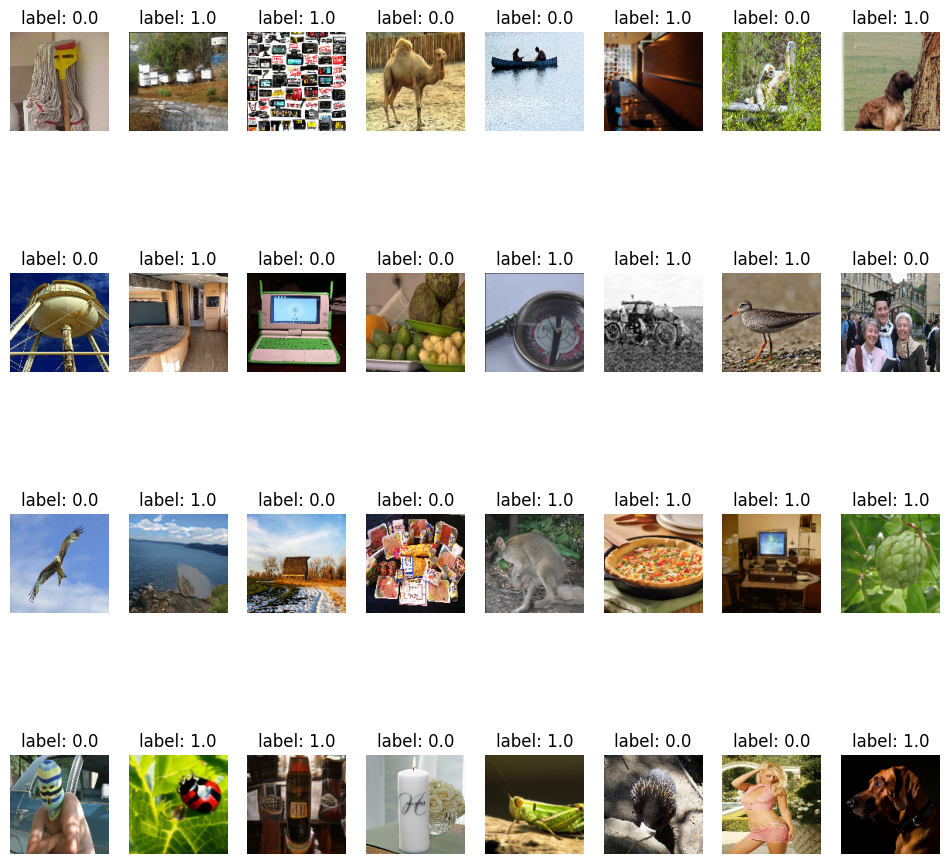

2026-02-14 16:32:18.070582: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [45]:

for images, labels in train_ds_final.take(1):
    batch_size_display = images.shape[0]
    imgs = images.numpy().astype('float32')/255.0
    plt.figure(figsize=(12, 12))
    for i in range(batch_size_display):
        plt.subplot(4, 8, i + 1)  #
        plt.imshow(imgs[i])
        plt.title(f"label: {labels[i].numpy()[0]}")
        plt.axis("off")
    plt.show()

In [21]:
model_basic_cnn = Sequential(
    [
        #input layer
        layers.Input(shape=(128, 128, 3)),
        # rescale
        layers.Rescaling(1./255),
        # convolutional layer
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")

    ]
)

In [22]:
model_basic_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,913 (2.39 MB)

 Trainable params: 626,913 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
adam = optimizers.Adam(learning_rate = 0.001)
model_basic_cnn.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [24]:
%%time
history_basic_cnn = model_basic_cnn.fit(
        train_ds_final,
        epochs=8,
        validation_data=val_ds_final
        )

Epoch 1/8


2026-02-14 16:39:32.375931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:20: Filling up shuffle buffer (this may take a while): 441 of 1000
2026-02-14 16:39:42.400343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


875/875 ━━━━━━━━━━━━━━━━━━━━ 133s 128ms/step - accuracy: 0.6185 - loss: 0.6478 - val_accuracy: 0.7526 - val_loss: 0.5180
Epoch 2/8
875/875 ━━━━━━━━━━━━━━━━━━━━ 106s 121ms/step - accuracy: 0.7515 - loss: 0.5231 - val_accuracy: 0.7872 - val_loss: 0.4566
Epoch 3/8
875/875 ━━━━━━━━━━━━━━━━━━━━ 110s 126ms/step - accuracy: 0.7835 - loss: 0.4735 - val_accuracy: 0.8073 - val_loss: 0.4201
Epoch 4/8
875/875 ━━━━━━━━━━━━━━━━━━━━ 106s 121ms/step - accuracy: 0.8000 - loss: 0.4473 - val_accuracy: 0.8054 - val_loss: 0.4200
Epoch 5/8
875/875 ━━━━━━━━━━━━━━━━━━━━ 106s 121ms/step - accuracy: 0.8164 - loss: 0.4152 - val_accuracy: 0.8234 - val_loss: 0.4100
Epoch 6/8
875/875 ━━━━━━━━━━━━━━━━━━━━ 112s 127ms/step - accuracy: 0.8305 - loss: 0.3881 - val_accuracy: 0.8359 - val_loss: 0.3840
Epoch 7/8
875/875 ━━━━━━━━━━━━━━━━━━━━ 109s 125ms/step - accuracy: 0.8450 - loss: 0.3586 - val_accuracy: 0.8307 - val_loss: 0.3847
Epoch 8/8
875/875 ━━━━━━━━━━━━━━━━━━━━ 106s 121ms/step - accuracy: 0.8531 - loss: 0.3385 - va

In [25]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,10))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


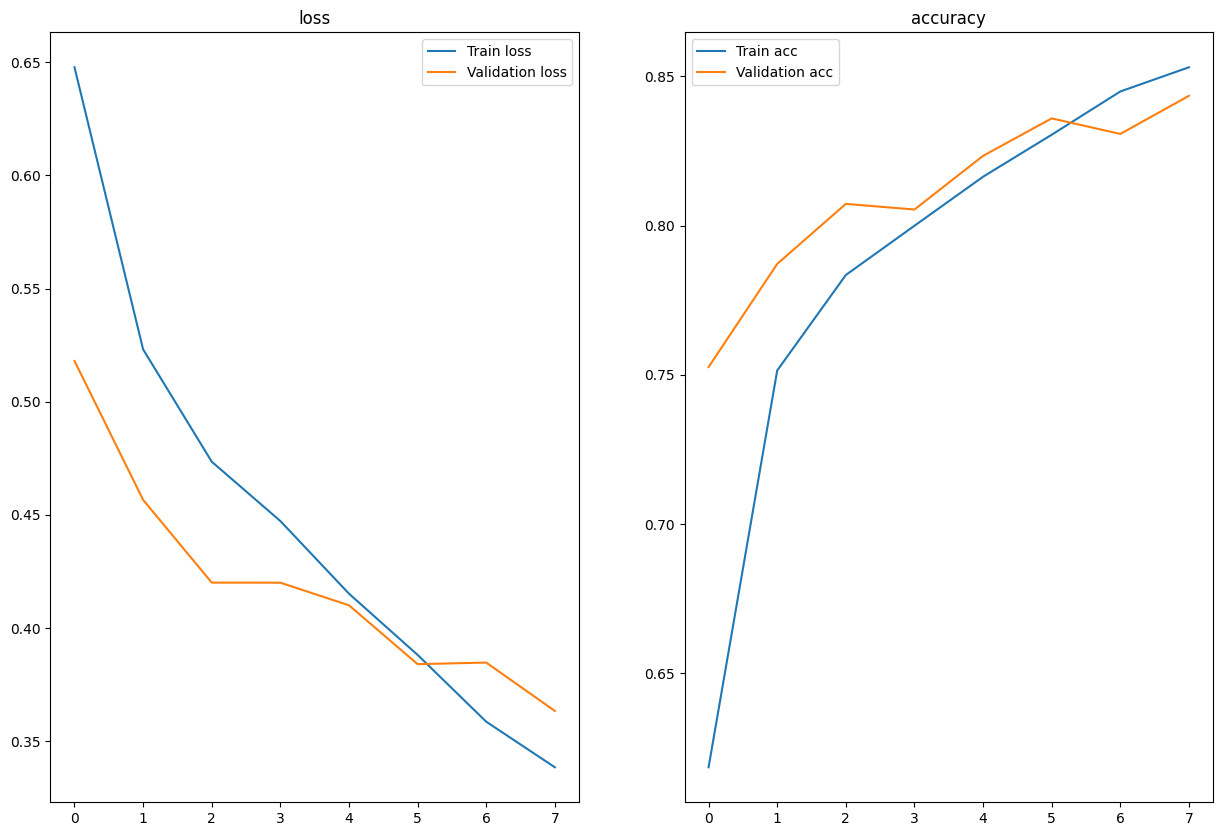

In [26]:
plot_history(history_basic_cnn)

In [27]:
# Compare the performance of 2 models
def plot_compare_history(history, name_history, history_1, name_history_1):

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)

    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)

    ax[1].set_title('Accuracy')


    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)

    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[0].legend()
    ax[1].legend()

In [28]:
model_basic_cnn.evaluate(test_ds_final)

87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8520 - loss: 0.3507


[0.3507034480571747, 0.852011501789093]

In [31]:
model_basic_cnn.save("../models/basic_cnn.keras")

In [32]:
cat = "https://www.wikichat.fr/wp-content/uploads/sites/2/comment-soigner-une-plaie-dun-chat.jpg"
cat2 = "http://create.votreveterinaire.com/adm/webmaster/_empty/upload/chat_surpris.jpg"


dog = "https://images.sudouest.fr/2018/04/14/5ace461a66a4bd2b1780a0dd/widescreen/1000x500/on-ignore-si-le-chihuahua-a-deserte-ou-non-les-locaux-de-la-clinique.jpg?v1"
dog2 = "https://ds1.static.rtbf.be/article/image/370x208/7/8/f/a20f02dfccd07952da54a7f9a82b3e89-1524657315.jpg"

In [34]:
import requests
from io import BytesIO

def get_image(url):
    img_size= (128,128)
    response = requests.get(url=url)
    img = Image.open(BytesIO(response.content))
    img = img.convert(mode="RGB")
    img = img.resize(img_size)
    print(f"picture size : {img_size}; mode : {img.mode}")
    return img


In [35]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def image_predict(url,model):
    img = get_image(url)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, 128, 128, 3))
    img_array = img_array / 255.0
    prediction = model.predict(img_array)
    result = round(prediction[0][0],2)
    print(result)
    plt.imshow(img)
    plt.axis('off')
    if result<0.5:
        print(f"There are {result*100}% that the picrure is real picture, which is lower than 50%")
        print("Therefore, the picture is not AI generated")
    if result>=0.5:
        print(f"There are {result*100}% that the picrure is AI picture, which is higher than 50%")
        print("Therefore, the picture is AI generated")

picture size : (128, 128); mode : RGB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
0.93
There are 93.0% that the picrure is AI picture, which is higher than 50%
Therefore, the picture is AI generated


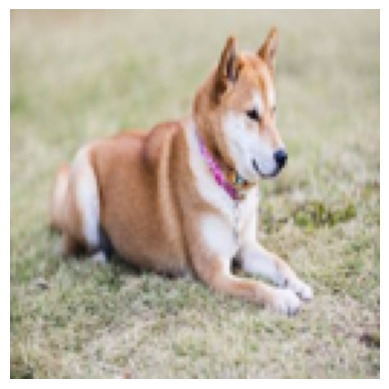

In [36]:
image_predict(dog2,model_basic_cnn)

picture size : (128, 128); mode : RGB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.93
There are 93.0% that the picrure is AI picture, which is higher than 50%
Therefore, the picture is AI generated


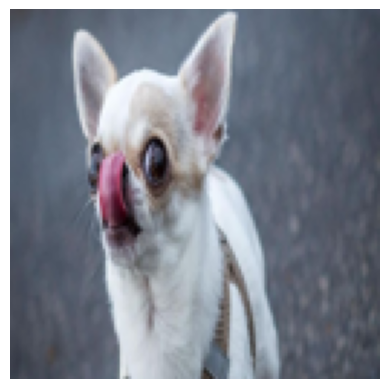

In [37]:
image_predict(dog,model_basic_cnn)

## Data augmentation

In [72]:
data_augmentation = Sequential(
    [
    layers.RandomFlip(mode="horizontal", seed=42),
    layers.RandomRotation(0.03),
    # keep zoom/contrast conservative to avoid introducing unrealistic samples
    ]
)

In [ ]:
model_augmentation = Sequential(
    [
        #input layer
        layers.Input(shape=(128, 128, 3)),
        # rescale
        layers.Rescaling(1./255),
        # augmentation
        data_augmentation,
        # convolutional layer
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")

    ]
)

In [75]:
model_augmentation.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,913 (2.39 MB)

 Trainable params: 626,913 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
adam = optimizers.Adam(learning_rate = 1e-4)
model_augmentation.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [77]:
MODEL = "../models/CNN_augmentaiton.keras"
modelCheckpoint = callbacks.ModelCheckpoint(filepath=MODEL,
                                            monitor="val_loss",
                                            verbose=0,
                                            save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                        factor=0.1,
                                        patience=3,
                                        verbose=1,
                                        min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss',
                                       patience=10,
                                       verbose=0,
                                       restore_best_weights=True)

In [ ]:
%%time
history_model_aug = model_augmentation.fit(
        train_ds_final,
        epochs=10,
        validation_data=val_ds_final,
        callbacks=[modelCheckpoint, LRreducer, EarlyStopper]
        )

In [81]:
history_model_aug.history

{'accuracy': [0.5388049483299255,
  0.5724490284919739,
  0.6034144163131714,
  0.660809338092804,
  0.7017393708229065,
  0.7210614681243896,
  0.7387049794197083,
  0.7480624318122864,
  0.7550626993179321,
  0.7598842978477478],
 'loss': [0.6867110729217529,
  0.6718056797981262,
  0.6531426310539246,
  0.6139058470726013,
  0.5790715217590332,
  0.5569323301315308,
  0.537935733795166,
  0.5257382392883301,
  0.5127337574958801,
  0.5034456849098206],
 'val_accuracy': [0.5490056872367859,
  0.5819128751754761,
  0.59375,
  0.6768465638160706,
  0.6877367496490479,
  0.640625,
  0.6946022510528564,
  0.6382575631141663,
  0.6666666865348816,
  0.6548295617103577],
 'val_loss': [0.6801311373710632,
  0.665425181388855,
  0.6610878705978394,
  0.625209391117096,
  0.6302339434623718,
  0.6807017922401428,
  0.5859047174453735,
  0.7077913284301758,
  0.6349380016326904,
  0.6605376601219177],
 'learning_rate': [0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
 

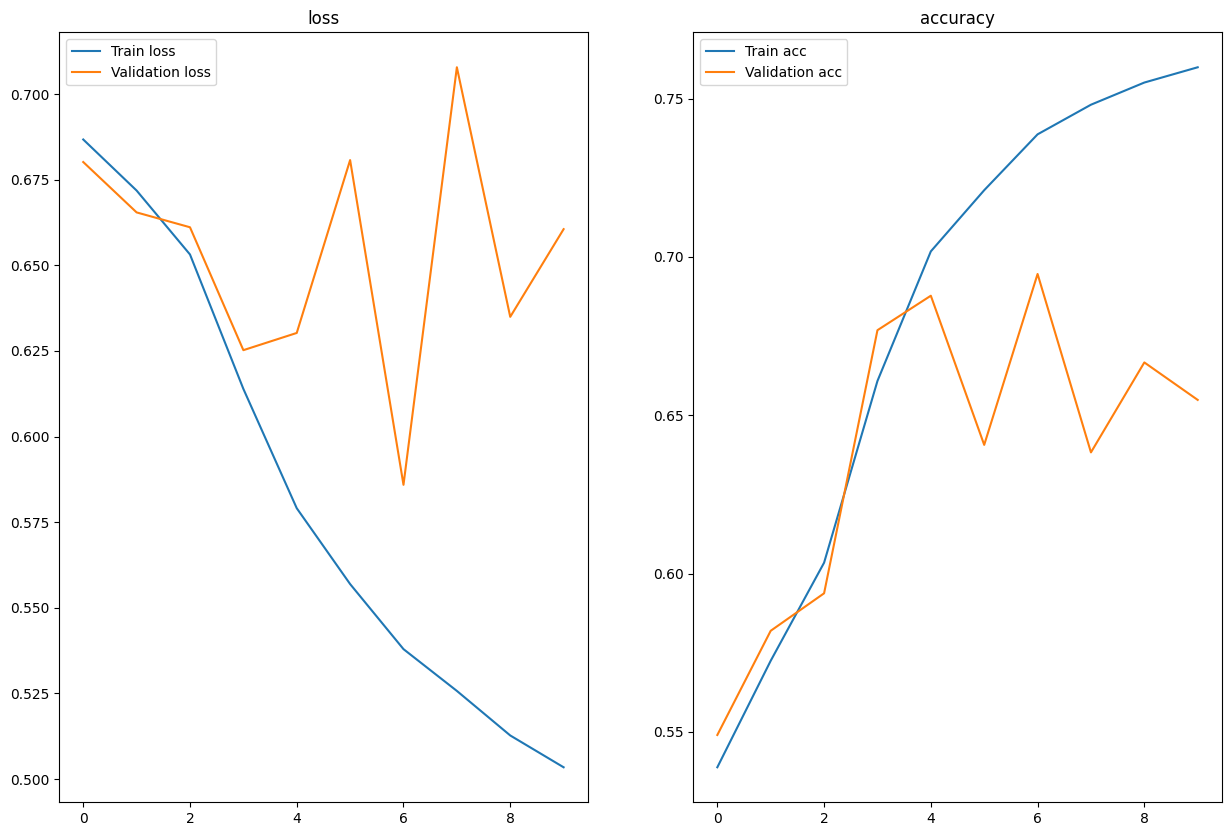

In [80]:
plot_history(history_model_aug)

picture size : (128, 128); mode : RGB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
0.63
There are 63.0% that the picrure is AI picture, which is higher than 50%
Therefore, the picture is AI generated


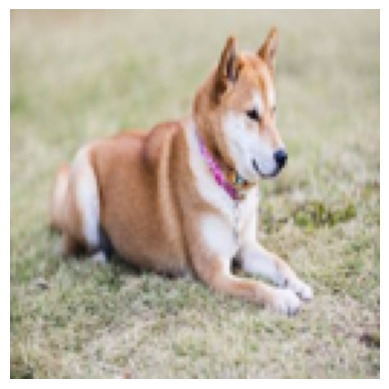

In [50]:
image_predict(dog2,model_augmentation)

picture size : (128, 128); mode : RGB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
0.62
There are 62.0% that the picrure is AI picture, which is higher than 50%
Therefore, the picture is AI generated


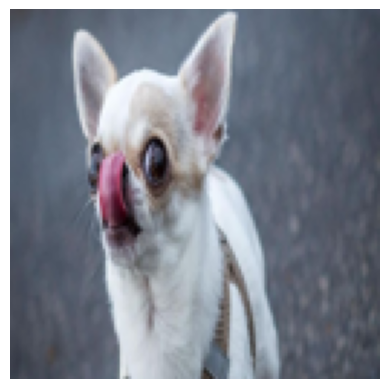

In [51]:
image_predict(dog,model_augmentation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0..247.43628].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [15.328377..231.3068].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [6.4052277..234.94765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..253.18098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [8.211723..244.63625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.35085526..255.0].


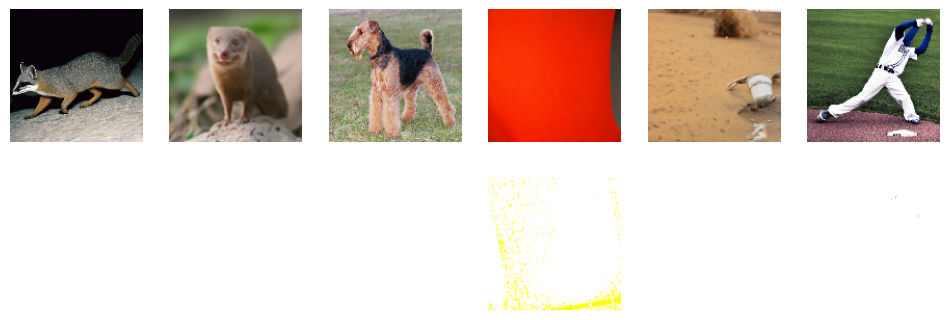

In [79]:
# visualize data augmentation
for imgs, _ in train_ds_final.take(1):
    imgs = imgs[:6]
    aug = data_augmentation(imgs)
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(2, 6, figsize=(12,4))
    for i in range(6):
        ax[0,i].imshow(imgs[i].numpy().astype("uint8"))
        ax[0,i].axis("off")
        ax[1,i].imshow(aug[i].numpy())
        ax[1,i].axis("off")
    plt.show()
    break